# Data Fit (Neural Networks): SIR data without noise

In [1]:
import os
import sys

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2025-06-25 10:08:44.610223: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-25 10:08:44.624573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750860524.641407 4120421 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750860524.646679 4120421 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750860524.660608 4120421 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Num GPUs Available:  1


## Load data 

In [3]:
# Load Simulated data
import pickle as pkl
data_path = '../../data/raw/simulated/SIR'
with open(f'{data_path}/sir.pkl', 'rb') as f:
    data_sim = pkl.load(f) 

## Division Training/Validation/Test

In [4]:
from sklearn.model_selection import train_test_split
import numpy as np

# Prepare data
X = [] # X will be the data from infected people
y = [] # y will be the parameters from that simulation

for simulation in data_sim:
    compartment_data = simulation[0]  # S, I, R matrix
    parameters = simulation[2]  # [beta, gamma]
    
    # Extract I values
    I_values = compartment_data[:, 1]  # second column columna (I compartment)
    
    X.append(I_values)  # Add to the characteristic list
    y.append(parameters)  # Add to label list

# Convert to numpy arrays
X = np.array(X) 
y = np.array(y) 

# First division: 99% training + validation, 1% test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

# Second división: 80% training, 20% validation. 
# General split: 79.2% training, 19.8% validation, 1% test
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Adding noise
for i, x in enumerate(X_test):
    # Add Gaussian noise (small)
    noise_std = np.mean(x)  # mean value
    noise = np.random.normal(0, noise_std, size=x.shape)
    X_test[i] = x + noise
    
# Imprimir formas para verificar
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (79200, 1001)
X_val shape: (19800, 1001)
X_test shape: (1000, 1001)
y_train shape: (79200, 2)
y_val shape: (19800, 2)
y_test shape: (1000, 2)


# SIR simulation for signal comparison

In [5]:
import numpy as np
from summer import CompartmentalModel

# Function to simulate the SIR model given beta and gamma
def simulate_SIR(beta, gamma, times=[0, 100], S0=90, I0=10):
    model = CompartmentalModel(
        times=times,
        compartments=["S", "I", "R"],
        infectious_compartments=["I"],
        timestep=0.1,
    )
    model.set_initial_population(distribution={"S": S0, "I": I0})
    model.add_infection_frequency_flow("infection", contact_rate=beta, source="S", dest="I")
    model.add_transition_flow("recovery", fractional_rate=gamma, source="I", dest="R")
    model.run()
    return model.outputs.T[1] # Infected compartment

# Vanilla Neural Network Model

In [6]:
%%time
import tensorflow as tf
from tensorflow.keras.activations import swish


model = tf.keras.models.Sequential() 
model.add(tf.keras.layers.InputLayer(input_shape=[1001])) 
model.add(tf.keras.layers.Dense(256, activation=swish))
model.add(tf.keras.layers.Dense(128, activation=swish))
model.add(tf.keras.layers.Dense(32, activation=swish))
model.add(tf.keras.layers.Dense(16, activation=swish))
model.add(tf.keras.layers.Dense(64, activation=swish))
model.add(tf.keras.layers.Dense(16, activation=swish)) 
model.add(tf.keras.layers.Dense(2, activation='linear')) 

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import AdamW

# Compile model
model.compile(
              optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5),
              loss = tf.keras.losses.Huber(delta=1e-4),
              metrics = [tf.keras.metrics.R2Score()])

early_stopping = EarlyStopping(monitor="val_r2_score", patience = 15, restore_best_weights=True) # Number of iterations without improvement (patience)

history = model.fit(X_train, y_train,
                    validation_data = (X_val, y_val), 
                    epochs=100,
                    callbacks = [early_stopping])

/home/polivares/miniforge3/envs/SIR/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1750860535.964840 4120421 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4149 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/100


I0000 00:00:1750860539.522721 4121205 service.cc:152] XLA service 0x787ee4010df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750860539.522738 4121205 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-06-25 10:08:59.564261: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750860539.899392 4121205 cuda_dnn.cc:529] Loaded cuDNN version 90300


  74/2475 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 6.5269e-05 - r2_score: -4.6974  

I0000 00:00:1750860540.789636 4121205 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2475/2475 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 1.0251e-05 - r2_score: 0.6133 - val_loss: 2.7563e-06 - val_r2_score: 0.9892
Epoch 2/100
2475/2475 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3.0013e-06 - r2_score: 0.9870 - val_loss: 2.2684e-06 - val_r2_score: 0.9895
Epoch 3/100
2475/2475 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 2.6468e-06 - r2_score: 0.9894 - val_loss: 1.5015e-06 - val_r2_score: 0.9953
Epoch 4/100
2475/2475 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 2.1048e-06 - r2_score: 0.9923 - val_loss: 2.7807e-06 - val_r2_score: 0.9833
Epoch 5/100
2475/2475 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.9664e-06 - r2_score: 0.9935 - val_loss: 1.7786e-06 - val_r2_score: 0.9953
Epoch 6/100
2475/2475 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 1.8641e-06 - r2_score: 0.9940 - val_loss: 1.1961e-06 - val_r2_score: 0.9970
Epoch 7/100
2475/2475 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 1.7124e-06 - r2_score: 0.9948 - val_loss: 1.5079e-06 - val_r2_score: 0.9952
Epoch 8/100
2475/2475 ━━━━━━━━━━━━━━━━

In [7]:
model.evaluate(X_test,y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.7612e-06 - r2_score: 0.9749


[3.676834239740856e-06, 0.9768159985542297]

In [8]:
y_pred = model.predict(X_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [10]:
# saving model
model.save("../../models/sir_vanillaNN_noise.h5")

In [11]:
from sklearn.metrics import r2_score

r2_combined = r2_score(y_test, y_pred, multioutput='uniform_average')

print(f"Combined R2Score for beta and gamma: {r2_combined}")

Combined R2Score for beta and gamma: 0.9768159979052636


In [12]:
# Save Params fitted
with open(f'{data_path}/test/sir_params_fit_VanillaNN_noise.pkl', 'wb') as f:
   pkl.dump(y_pred, f)

## Visual examples: estimated parameters vs real parameters.

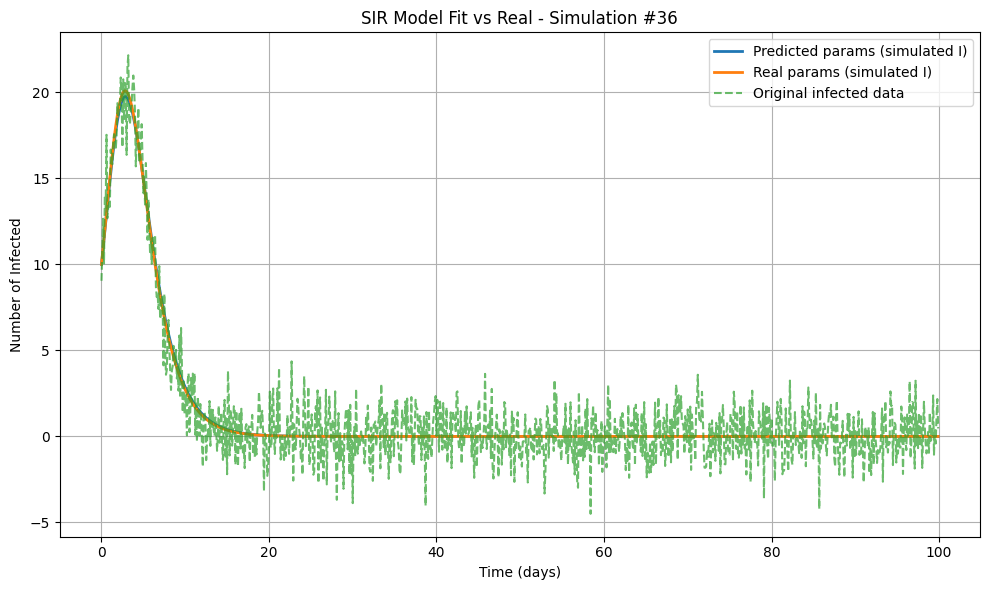

In [13]:
import matplotlib.pyplot as plt

# Example: simulation index to visualize
n_sim = 36

# True parameters
beta_real, gamma_real = y_test[n_sim]
# Estimated parameters
beta_pred, gamma_pred = y_pred[n_sim]

# Simulate using real and predicted parameters
solution_real_fit = simulate_SIR(beta_real, gamma_real)
solution_pred_fit = simulate_SIR(beta_pred, gamma_pred)

# Extract infected curves
I_real_model = solution_real_fit  # simulate_SIR returns only I
I_pred_model = solution_pred_fit
I_data = X_test[n_sim, :]  # Infected values from simulation (ground truth)

# Time vector (assume same as in model)
t = np.linspace(0, 100, len(I_data))
n_points = min(len(t), 1000)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t[:n_points], I_pred_model[:n_points], '-', label='Predicted params (simulated I)', linewidth=2)
plt.plot(t[:n_points], I_real_model[:n_points], '-', label='Real params (simulated I)', linewidth=2)
plt.plot(t[:n_points], I_data[:n_points], '--', label='Original infected data', alpha=0.7)
plt.xlabel('Time (days)')
plt.ylabel('Number of Infected')
plt.title(f'SIR Model Fit vs Real - Simulation #{n_sim}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Comparison: $\beta_{real}$ vs $\beta_{pred}$

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


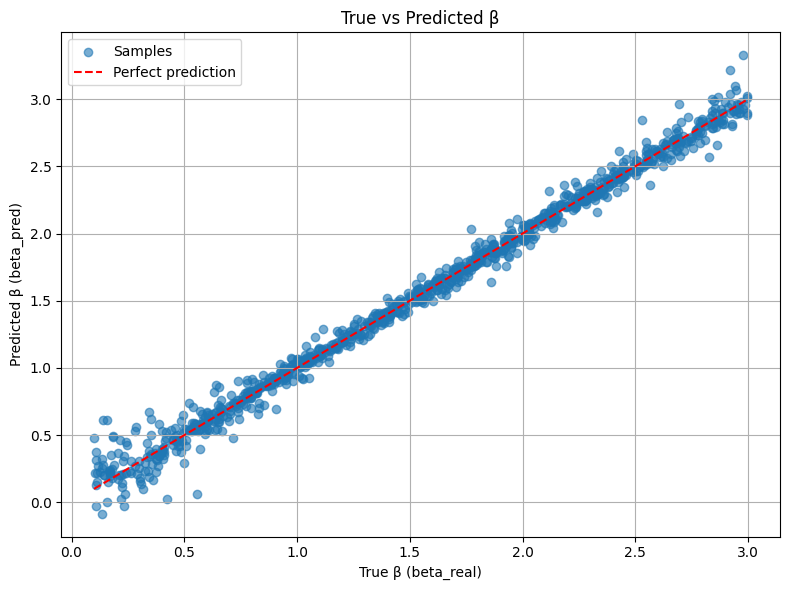

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Extract beta from predictions and true values
beta_real = y_test[:, 0]
beta_pred = model.predict(X_test)[:, 0]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(beta_real, beta_pred, alpha=0.6, label='Samples')
plt.plot([beta_real.min(), beta_real.max()], [beta_real.min(), beta_real.max()], 'r--', label='Perfect prediction')
plt.xlabel('True β (beta_real)')
plt.ylabel('Predicted β (beta_pred)')
plt.title('True vs Predicted β')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Comparison: $\gamma_{real}$ vs $\gamma_{pred}$

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


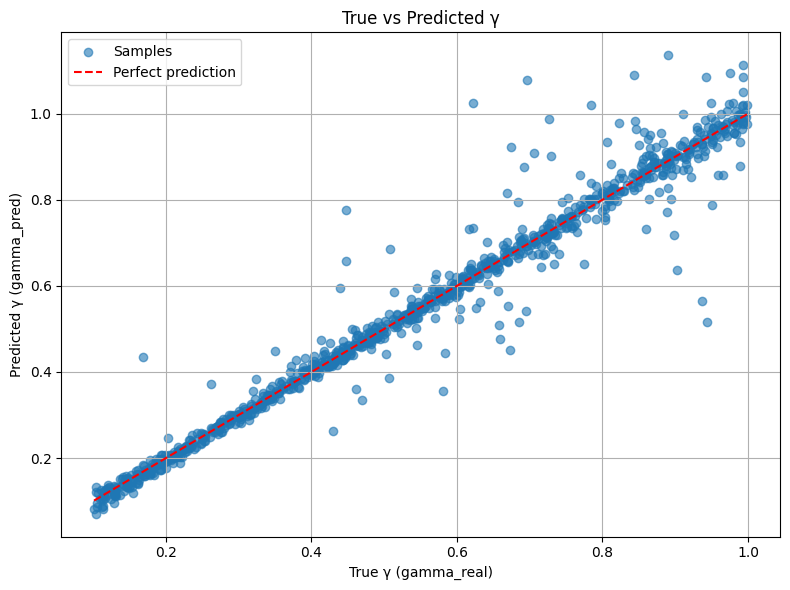

In [15]:
import matplotlib.pyplot as plt

# Extract gamma from predictions and true values
gamma_real = y_test[:, 1]
gamma_pred = model.predict(X_test)[:, 1]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(gamma_real, gamma_pred, alpha=0.6, label='Samples')
plt.plot([gamma_real.min(), gamma_real.max()],
         [gamma_real.min(), gamma_real.max()], 'r--', label='Perfect prediction')
plt.xlabel('True γ (gamma_real)')
plt.ylabel('Predicted γ (gamma_pred)')
plt.title('True vs Predicted γ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Other architectures: branched architecture

In [16]:
%%time
import tensorflow as tf
from tensorflow.keras.activations import swish
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import AdamW

# Input layer
inputs = tf.keras.Input(shape=(1001,))

# Shared base
x = Dense(256, activation=swish)(inputs)
x = Dense(128, activation=swish)(x)
x = Dense(32, activation=swish)(x)
x = Dense(16, activation=swish)(x)

# Branch for beta
b = Dense(64, activation=swish)(x)
b = Dense(16, activation=swish)(b)
b = Dense(1, activation='linear')(b)

# Branch for gamma
g = Dense(64, activation=swish)(x)
g = Dense(16, activation=swish)(g)
g = Dense(1, activation='linear')(g)

# Concatenate outputs
outputs = Concatenate()([b, g])

# Final model
model_branched = Model(inputs=inputs, outputs=outputs)

# Compile model
model_branched.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5),
    loss=tf.keras.losses.Huber(delta=1e-4),
    metrics=[tf.keras.metrics.R2Score()]
)

# Early stopping
early_stopping = EarlyStopping(monitor="val_r2_score", patience=15, restore_best_weights=True)

# Train
history = model_branched.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    callbacks=[early_stopping])


Epoch 1/100
2475/2475 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 8.1222e-06 - r2_score: 0.7867 - val_loss: 2.8197e-06 - val_r2_score: 0.9889
Epoch 2/100
2475/2475 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 2.9719e-06 - r2_score: 0.9881 - val_loss: 2.4774e-06 - val_r2_score: 0.9916
Epoch 3/100
2475/2475 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 2.3280e-06 - r2_score: 0.9916 - val_loss: 2.3010e-06 - val_r2_score: 0.9894
Epoch 4/100
2475/2475 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 2.1459e-06 - r2_score: 0.9925 - val_loss: 1.8960e-06 - val_r2_score: 0.9939
Epoch 5/100
2475/2475 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 1.8981e-06 - r2_score: 0.9938 - val_loss: 1.4439e-06 - val_r2_score: 0.9949
Epoch 6/100
2475/2475 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 1.6708e-06 - r2_score: 0.9948 - val_loss: 1.5211e-06 - val_r2_score: 0.9967
Epoch 7/100
2475/2475 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 1.6411e-06 - r2_score: 0.9950 - val_loss: 1.3722e-06 - val_r2_score: 0.9961
Epoch 8/100
2475/2475 ━━━━

In [17]:
model_branched.evaluate(X_test,y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.8626e-06 - r2_score: 0.9632


[3.7337811136239907e-06, 0.9695284962654114]

In [18]:
y_pred_br = model_branched.predict(X_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [19]:
# saving model
model_branched.save("../../models/sir_branchedNN_noise.h5")

In [20]:
from sklearn.metrics import r2_score

r2_combined = r2_score(y_test, y_pred_br, multioutput='uniform_average')

print(f"Combined R2Score for beta and gamma: {r2_combined}")

Combined R2Score for beta and gamma: 0.9695284919218471


In [21]:
# Save Params fitted
with open(f'{data_path}/test/sir_params_fit_BranchedNN_noise.pkl', 'wb') as f:
   pkl.dump(y_pred_br, f)

## Visual examples: estimated parameters vs real parameters.

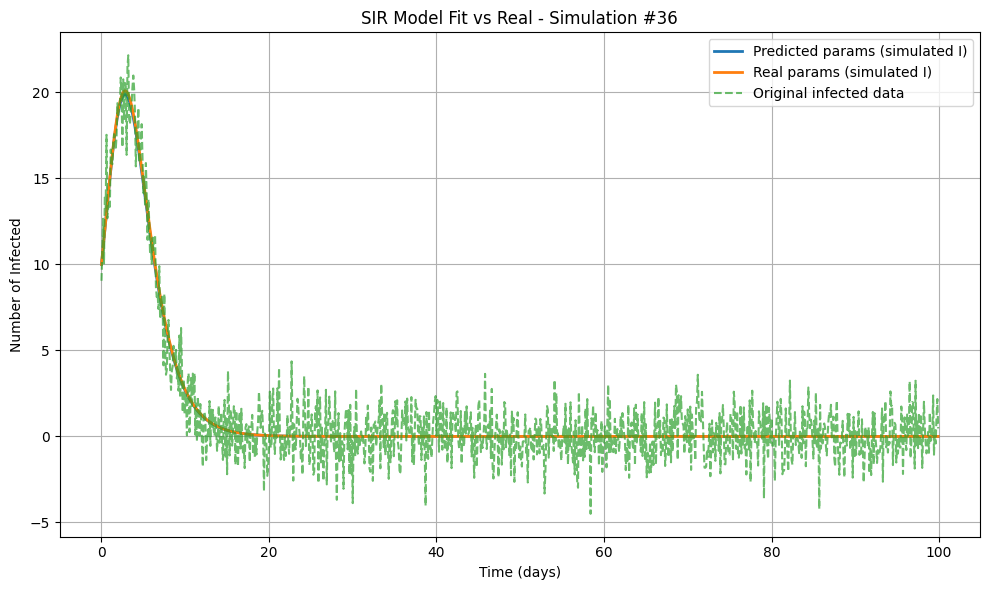

In [22]:
import matplotlib.pyplot as plt

# Example: simulation index to visualize
n_sim = 36

# True parameters
beta_real, gamma_real = y_test[n_sim]
# Estimated parameters
beta_pred, gamma_pred = y_pred_br[n_sim]

# Simulate using real and predicted parameters
solution_real_fit = simulate_SIR(beta_real, gamma_real)
solution_pred_fit = simulate_SIR(beta_pred, gamma_pred)

# Extract infected curves
I_real_model = solution_real_fit  # simulate_SIR returns only I
I_pred_model = solution_pred_fit
I_data = X_test[n_sim, :]  # Infected values from simulation (ground truth)

# Time vector (assume same as in model)
t = np.linspace(0, 100, len(I_data))
n_points = min(len(t), 1000)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t[:n_points], I_pred_model[:n_points], '-', label='Predicted params (simulated I)', linewidth=2)
plt.plot(t[:n_points], I_real_model[:n_points], '-', label='Real params (simulated I)', linewidth=2)
plt.plot(t[:n_points], I_data[:n_points], '--', label='Original infected data', alpha=0.7)
plt.xlabel('Time (days)')
plt.ylabel('Number of Infected')
plt.title(f'SIR Model Fit vs Real - Simulation #{n_sim}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Comparison: $\beta_{real}$ vs $\beta_{pred}$

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


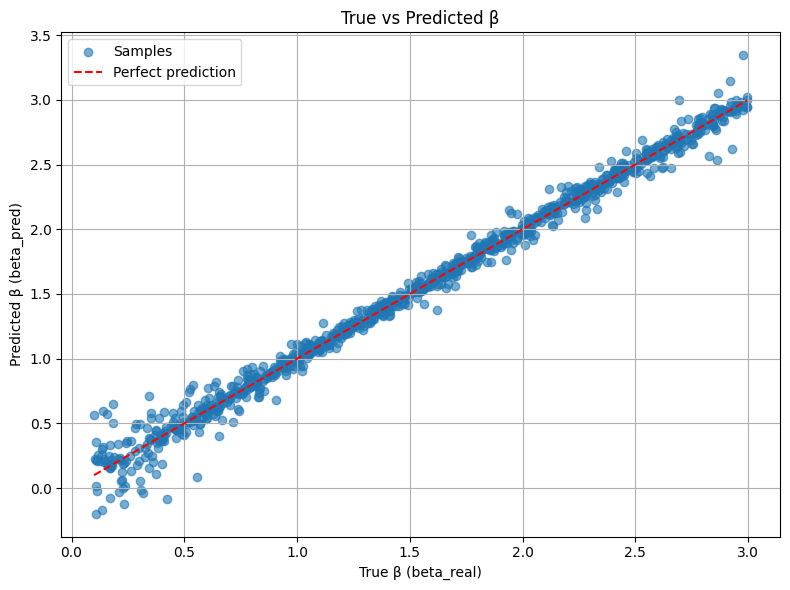

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Extract beta from predictions and true values
beta_real = y_test[:, 0]
beta_pred = model_branched.predict(X_test)[:, 0]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(beta_real, beta_pred, alpha=0.6, label='Samples')
plt.plot([beta_real.min(), beta_real.max()], [beta_real.min(), beta_real.max()], 'r--', label='Perfect prediction')
plt.xlabel('True β (beta_real)')
plt.ylabel('Predicted β (beta_pred)')
plt.title('True vs Predicted β')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Comparison: $\gamma_{real}$ vs $\gamma_{pred}$

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


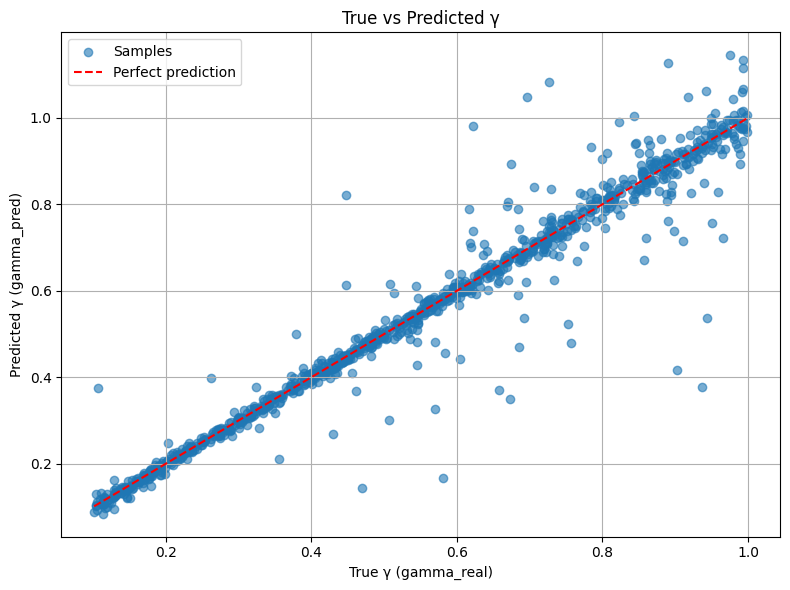

In [24]:
import matplotlib.pyplot as plt

# Extract gamma from predictions and true values
gamma_real = y_test[:, 1]
gamma_pred = model_branched.predict(X_test)[:, 1]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(gamma_real, gamma_pred, alpha=0.6, label='Samples')
plt.plot([gamma_real.min(), gamma_real.max()],
         [gamma_real.min(), gamma_real.max()], 'r--', label='Perfect prediction')
plt.xlabel('True γ (gamma_real)')
plt.ylabel('Predicted γ (gamma_pred)')
plt.title('True vs Predicted γ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()